In [1]:
# 초기설정
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.13.1
GPU Available: True


In [2]:
# 라이브러리 임포트
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# torchvision과 transforms: PyTorch의 torchvision 라이브러리를 사용하여 이미지 처리 및 데이터셋 관리를 수행합니다.
# transform: MNIST 데이터셋의 이미지를 텐서로 변환하고 정규화합니다. 정규화는 평균을 0.5, 표준편차를 0.5로 설정합니다.
# mnist_dataset: MNIST 데이터셋을 로드합니다. 이 데이터셋은 손으로 쓴 숫자 이미지로 구성되어 있습니다.

import torchvision
from torchvision import transforms

# 이미지 경로와 변환(전처리) 설정
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# MNIST 데이터셋을 불러오고 전처리 적용
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

In [4]:
# batch_size: 한 번에 처리할 이미지 수를 설정합니다.
# torch.manual_seed와 np.random.seed: 일관된 결과를 위해 난수 생성기의 시드를 설정합니다.
# mnist_dl: 데이터 로더를 생성하여 데이터셋에서 이미지를 배치 단위로 로드합니다.
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

# 데이터 로더 설정
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)

In [5]:
# 생성자 네트워크 정의
# nn.ConvTranspose2d: 이 라인은 전치 합성곱(ConvTranspose) 레이어를 생성합니다. 이 레이어는 이미지의 공간 차원을 업샘플링하고 특성 맵을 생성하는 데 사용됩니다. input_size 크기의 입력을 받아 n_filters*4 개의 채널로 변환합니다.
# nn.BatchNorm2d: Batch Normalization은 학습을 안정화시키고 모델의 성능을 향상시키는 데 사용됩니다. 이것은 미니 배치 내부의 입력을 정규화하는 데 도움을 줍니다.
# nn.LeakyReLU(0.2): LeakyReLU 활성화 함수를 적용합니다. 이것은 음수 입력에 대해 작은 기울기를 갖도록 하여 그래디언트 소실 문제를 완화합니다.
# , 이러한 레이어들을 연속적으로 쌓아서 Generator 네트워크를 구성합니다. 네트워크는 잡음 벡터로부터 점차적으로 고해상도 이미지를 생성합니다.
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

# 판별자 네트워크 정의
# Discriminator 네트워크의 첫 번째 레이어는 Conv2d 레이어로, 입력 이미지를 받아 채널 수를 늘리고 공간 차원을 줄입니다. LeakyReLU 활성화 함수를 사용하여 음수 입력에 대해 작은 기울기를 갖도록 합니다.
# 두 번째 레이어는 채널 수를 더 늘리고 공간 차원을 줄입니다. 또한 Batch Normalization과 LeakyReLU를 적용합니다.
# 세 번째 레이어에서도 채널 수를 늘리고 공간 차원을 줄이며 Batch Normalization과 LeakyReLU를 사용합니다.
# 마지막 레이어는 Conv2d 레이어로, 1개의 채널로 출력을 생성하며 Sigmoid 활성화 함수를 사용하여 이미지가 진짜인지 가짜인지를 판단하는 이진 분류 확률을 출력합니다.

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [6]:
# gen_model과 disc_model은 생성된 Generator와 Discriminator 모델을 나타냅니다.
# Generator 모델은 ConvTranspose2d 레이어를 사용하여 이미지를 생성합니다. 이 모델은 크게 4개의 ConvTranspose2d 레이어로 구성되어 있으며, 각 레이어는 BatchNorm2d와 LeakyReLU 활성화 함수가 뒤따릅니다. 마지막 레이어에서는 Tanh 활성화 함수를 사용하여 출력을 생성합니다.
# 판별자 모델은 Conv2d 레이어를 사용하여 이미지를 판별합니다. 이 모델은 네 개의 Conv2d 레이어로 구성되어 있으며, 각 레이어는 LeakyReLU 활성화 함수와 BatchNorm2d를 포함하고 있습니다. 마지막 레이어에서는 Sigmoid 활성화 함수를 사용하여 확률 값을 출력합니다.
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = make_generator_network(z_size, n_filters).to(device)  
print(gen_model)
disc_model = Discriminator(n_filters).to(device)     
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [7]:
# 손실 함수 및 옵티마이저 설정
# loss_fn은 이진 교차 엔트로피 (Binary Cross-Entropy) 손실 함수를 나타냅니다. 이 함수는 GAN 모델에서 사용되며, 생성자와 판별자의 손실을 계산하는 데에 활용됩니다.
# g_optimizer는 생성자 모델의 가중치를 업데이트하기 위한 Adam 옵티마이저를 생성합니다. 학습률은 0.0003으로 설정됩니다.
# d_optimizer는 판별자 모델의 가중치를 업데이트하기 위한 Adam 옵티마이저를 생성합니다. 학습률은 0.0002로 설정됩니다.
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [8]:
# 무작위 노이즈 생성 함수
# create_noise 함수는 GAN 생성자에 입력으로 사용할 무작위 노이즈 벡터를 생성하는 함수입니다. batch_size는 배치 크기, z_size는 노이즈 벡터의 크기, mode_z는 노이즈 생성 모드로 'uniform' 또는 'normal' 중 하나를 선택할 수 있습니다. 선택한 모드에 따라 무작위 노이즈를 생성하고 반환합니다.
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [9]:
# 판별자 학습 함수 정의
# d_train 함수는 Discriminator 모델을 학습하는 함수입니다. 이 함수는 실제 데이터 배치(x)를 사용하여 판별자를 학습한 후, 가짜 데이터 배치를 생성하고 판별자를 학습합니다.
# 먼저, disc_model.zero_grad()를 호출하여 판별자의 그레디언트를 초기화합니다.
# 실제 데이터에 대한 판별자의 출력 확률(d_proba_real)과 손실(d_loss_real)을 계산합니다. 실제 데이터에 대한 정답 레이블은 1로 표시됩니다.
# 가짜 데이터를 생성하고 판별자 모델(gen_model)을 통해 가짜 데이터에 대한 판별자의 출력 확률(d_proba_fake)과 손실(d_loss_fake)을 계산합니다. 가짜 데이터에 대한 정답 레이블은 0으로 표시됩니다.
# 실제 데이터와 가짜 데이터에 대한 손실을 합하여 판별자의 총 손실(d_loss)을 계산합니다.
# 손실을 역전파하고, 판별자 모델의 파라미터만 업데이트합니다.
# 함수는 판별자의 손실 값, 실제 데이터에 대한 판별자의 출력 확률, 가짜 데이터에 대한 판별자의 출력 확률을 반환합니다.
def d_train(x):
    disc_model.zero_grad()

    # 실제 데이터 배치로 판별자 학습
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # 가짜 데이터 배치로 판별자 학습
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # 그라디언트 역전파 및 판별자 모델의 파라미터만 업데이트
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [10]:
# 생성자 학습 함수
# g_train 함수는 생성자 모델(G)을 학습하는 함수입니다. 먼저, 생성자 모델의 그레디언트를 초기화하고, 입력 노이즈(input_z)를 생성합니다.
# 생성자의 출력(g_output)을 계산하고, 이를 판별자 모델(disc_model)을 통해 판별한 가짜 데이터의 확률(d_proba_fake)을 얻습니다.
# 생성자 손실(g_loss)은 판별자가 가짜 데이터를 실제로 받아들이도록 만들기 위해 이 확률을 1에 가깝게 만드는 것을 목표로 합니다.
# 손실을 역전파하고, 생성자 모델의 파라미터만 업데이트합니다. 함수는 생성자의 손실 값을 반환합니다.
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # 그레디언트 역전파 및 생성자 모델의 파라미터만 업데이트
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [13]:
# 모델 학습
# 모델 학습 루프는 GAN 모델을 훈련하는 부분입니다. 지정된 에포크 수(num_epochs) 동안 반복됩니다.
# 각 에포크에서 생성자 모델을 학습 모드로 설정하고, 실제 데이터와 가짜 데이터에 대한 손실을 저장할 리스트인 d_losses와 g_losses를 초기화합니다.
# 데이터 로더(mnist_dl)를 통해 미니배치(x)를 가져와 판별자와 생성자를 번갈아가며 학습합니다. d_train 함수와 g_train 함수를 호출하여 손실을 계산하고 리스트에 추가합니다.
# 각 에포크가 끝날 때마다 생성자 모델을 평가 모드로 전환하고, 고정된 노이즈(fixed_z)를 입력으로 사용하여 생성한 이미지 샘플을 epoch_samples 리스트에 추가합니다.
# 각 에포크에서의 생성자 및 판별자 손실 및 학습 진행 상황을 출력합니다.
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

# 에포크 수를 50으로 줄임
num_epochs = 50
torch.manual_seed(1)

# 이전에 초기화된 리스트들을 유지합니다.
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []

for epoch in range(1, num_epochs + 1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        
        # 손실 값을 바로 리스트에 추가
        all_d_losses.append(d_loss)
        all_g_losses.append(g_train(x))

        # 판별자의 출력을 바로 리스트에 추가
        all_d_real.append(d_proba_real.mean().item())
        all_d_fake.append(d_proba_fake.mean().item())
 
    # 에포크 별 평균 손실을 계산하지 않고, 모든 손실 값을 기록
    # 손실 값 출력
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.mean(torch.tensor(all_g_losses[-len(mnist_dl):])):.4f}'
          f'/{torch.mean(torch.tensor(all_d_losses[-len(mnist_dl):])):.4f}')
    
    gen_model.eval()
    # 생성된 이미지 샘플을 epoch_samples 리스트에 추가
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 3.1229/0.3374
Epoch 002 | Avg Losses >> G/D 2.8761/0.3470
Epoch 003 | Avg Losses >> G/D 2.8418/0.3519
Epoch 004 | Avg Losses >> G/D 2.8653/0.3606
Epoch 005 | Avg Losses >> G/D 2.8675/0.3332
Epoch 006 | Avg Losses >> G/D 2.9468/0.3077
Epoch 007 | Avg Losses >> G/D 2.9607/0.3161
Epoch 008 | Avg Losses >> G/D 3.0159/0.2987
Epoch 009 | Avg Losses >> G/D 3.0434/0.3014
Epoch 010 | Avg Losses >> G/D 3.0488/0.2869
Epoch 011 | Avg Losses >> G/D 3.1507/0.2593
Epoch 012 | Avg Losses >> G/D 3.2933/0.2524
Epoch 013 | Avg Losses >> G/D 3.2292/0.2574
Epoch 014 | Avg Losses >> G/D 3.3560/0.2472
Epoch 015 | Avg Losses >> G/D 3.3276/0.2537
Epoch 016 | Avg Losses >> G/D 3.4694/0.2523
Epoch 017 | Avg Losses >> G/D 3.4841/0.2274
Epoch 018 | Avg Losses >> G/D 3.5779/0.2264
Epoch 019 | Avg Losses >> G/D 3.5256/0.2332
Epoch 020 | Avg Losses >> G/D 3.5766/0.2370
Epoch 021 | Avg Losses >> G/D 3.6869/0.2047
Epoch 022 | Avg Losses >> G/D 3.5759/0.2206
Epoch 023 | Avg Losses >> G/D 3.

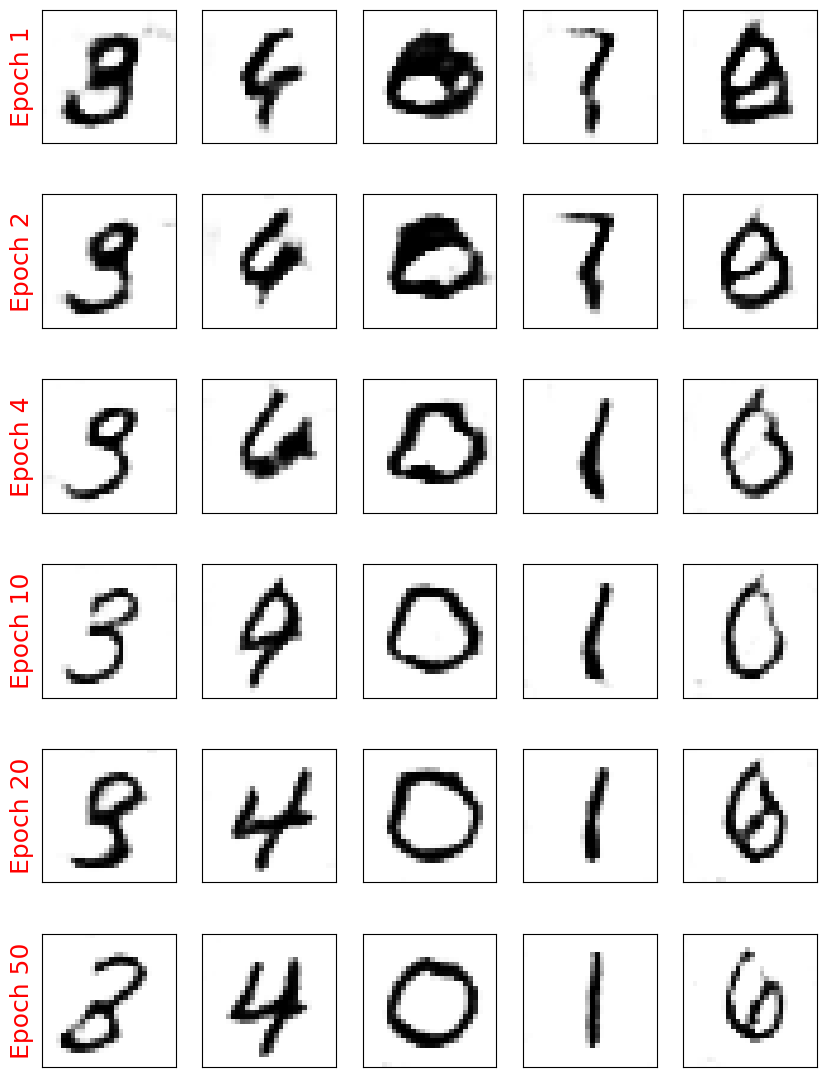

In [14]:
# 선택한 에포크에서 생성된 이미지 샘플을 시각적으로 확인할 수 있습니다.
selected_epochs = [1, 2, 4, 10, 20, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()

In [15]:
# Implementing WGAN-GP to train the DCGAN model

In [16]:
# WGAN 생성자 네트워크 정의
# 이 함수는 input_size와 n_filters라는 두 개의 인자를 받습니다.
# nn.ConvTranspose2d는 전치 합성곱 레이어로, 입력 데이터를 업샘플링하는 역할을 합니다. input_size 크기의 입력을 n_filters*4 크기로 업샘플링합니다. 여기서 커널 크기는 4x4이고, 스트라이드는 1이며, 패딩은 0입니다. bias=False는 편향을 사용하지 않음을 의미합니다.
# nn.InstanceNorm2d는 배치 정규화를 수행하는 레이어입니다. 이것은 네트워크의 안정성을 높이고 더 나은 수렴을 돕는 역할을 합니다.
# nn.LeakyReLU는 Leaky ReLU 활성화 함수를 적용하는 레이어입니다. Leaky ReLU는 입력의 음수 부분에 작은 기울기를 부여하여 그래디언트 소실 문제를 해결합니다. 이 함수는 생성자 네트워크에서 사용됩니다.
# 마지막 레이어는 출력 이미지를 생성하는 역할을 합니다. 여기서 출력 채널 수는 1로 설정되며, 커널 크기는 4x4이고, 스트라이드는 2이며, 패딩은 1입니다.

def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

# WGAN 판별자 네트워크 정의
# n_filters라는 인자를 받습니다.
# self.network라는 순차적인 네트워크 모듈을 정의합니다.
# 첫 번째 레이어는 입력 이미지를 받아들이는 합성곱 레이어로, nn.Conv2d를 사용합니다. 입력 이미지는 흑백 이미지이므로 채널 수는 1입니다. 출력 채널 수는 n_filters로 설정되며, 커널 크기는 4x4, 스트라이드는 2, 패딩은 1로 설정됩니다.
# 두 번째 합성곱 레이어에서는 출력 채널 수를 n_filters*2로 늘리고, 나머지 설정은 이전과 유사합니다.
# 마지막 레이어에서는 판별 결과를 출력하기 위해 Sigmoid 활성화 함수를 사용합니다.
class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [17]:
# make_generator_network_wgan 함수를 사용하여 Wasserstein GAN (WGAN) 생성자 모델을 생성합니다. 이 모델은 z_size 크기의 잠재 벡터를 입력으로 받고, n_filters 크기의 필터를 사용하여 이미지를 생성합니다. .to(device)는 모델을 지정된 디바이스 (예: GPU 또는 CPU)로 이동시킵니다.
# DiscriminatorWGAN 클래스를 사용하여 WGAN 판별자 모델을 생성합니다. 이 판별자 모델은 n_filters 크기의 필터를 사용하여 이미지를 판별합니다. 마찬가지로 .to(device)를 사용하여 모델을 지정된 디바이스로 이동시킵니다.
# g_optimizer, d_optimizer는 생성자, 판별자 모델의 학습을 위한 Adam 최적화기
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)  
disc_model = DiscriminatorWGAN(n_filters).to(device)  

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [18]:
# WGAN에서 GP 계산하는 함수
#  Gradient Penalty는 WGAN에서 사용되며, 판별자 네트워크의 그래디언트가 1에 가까워지도록 제한합니다.
# lambda_gp는 Gradient Penalty의 크기를 조절하는 하이퍼파라미터입니다. 이 함수는 WGAN 모델의 학습 중에 사용되어 경사 하강법 최적화 단계에서 판별자의 그래디언트를 제한하는 데 도움을 줍니다.
from torch.autograd import grad as torch_grad

def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # 보간(interpolation) 계산
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    
    # 보간된 예제의 확률 계산
    proba_interpolated = disc_model(interpolated)

    # 확률에 대한 예제의 그래디언트 계산
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    
    # Gradient Penalty 계산
    return lambda_gp * ((gradients_norm - 1)**2).mean()

In [19]:
# 판별자 학습
# disc_model.zero_grad(): 판별자 네트워크의 그래디언트를 초기화합니다.
# x = x.to(device): 입력 데이터를 GPU 또는 CPU로 이동합니다.
# d_real 및 d_generated은 각각 실제 데이터와 생성된 데이터에 대한 판별자의 출력 확률을 계산합니다.
# input_z는 잡음 벡터를 생성하고 해당 잡음 벡터를 생성자 모델 (gen_model)을 사용하여 가짜 이미지로 변환합니다.
# d_loss는 WGAN의 손실 함수로, 생성된 데이터와 실제 데이터에 대한 평균 확률의 차이에 Gradient Penalty를 추가한 값입니다.
# d_loss.backward(): 역전파를 수행하여 그래디언트를 계산합니다.
# d_optimizer.step(): 판별자 네트워크의 파라미터를 업데이트합니다.
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # 실제 데이터와 생성된 데이터에 대한 확률 계산
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)

    # 판별자의 손실 계산
    # WGAN의 중요한 특징 중 하나인 Gradient Penalty도 추가됨
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item()

In [20]:
# 생성자 학습
# gen_model.zero_grad(): 생성자 네트워크의 그래디언트를 초기화합니다.
# batch_size와 input_z를 설정합니다. input_z는 잡음 벡터를 나타내며, 이 벡터는 생성자 모델 (gen_model)을 통해 가짜 이미지를 생성하는 데 사용됩니다.
# g_output은 생성자 모델을 통해 생성된 가짜 이미지를 나타냅니다.
# d_generated는 생성된 이미지에 대한 판별자의 출력 확률을 계산합니다.
# g_loss는 생성자의 손실로, 판별자의 출력을 최대화하는 방향으로 계산됩니다.
# g_loss.backward(): 역전파를 수행하여 그래디언트를 계산합니다.
# g_optimizer.step(): 생성자 네트워크의 파라미터를 업데이트합니다.
def g_train_wgan(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_generated = disc_model(g_output)
    
    # 생성자의 손실 계산
    # 판별자의 출력을 최대화하여 생성자를 학습함
    g_loss = -d_generated.mean()

    # 그래디언트 백프로파게이션 및 오직 생성자 파라미터만 업데이트
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [22]:
# WGAN을 사용하여 생성자와 판별자를 번갈아가며 학습시키는 학습 루프를 나타냅니다.
# 그래디언트 페널티 하이퍼파라미터 lambda_gp 및 크리틱(iterations) 당 반복 횟수 critic_iterations를 설정하여 학습을 조절합니다.
epoch_samples_wgan = []  # 에포크별로 생성된 샘플 이미지 저장
lambda_gp = 5.0  # 그래디언트 페널티 하이퍼파라미터
num_epochs = 10  # 전체 에포크 수
torch.manual_seed(1)  # 랜덤 시드 설정
critic_iterations = 3  # 크리틱(iterations) 당 반복 횟수

# 전체 에포크 수만큼 루프 실행
for epoch in range(1, num_epochs+1):
    gen_model.train()  # 생성자 모델을 학습 모드로 설정
    d_losses, g_losses = [], []  # 판별자와 생성자의 손실을 저장하는 리스트
    
    # 미니배치 데이터로 루프 실행
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            # 판별자를 학습하고 그래디언트 페널티를 적용하여 손실 계산
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)  # 판별자 손실 저장
        g_losses.append(g_train_wgan(x))  # 생성자 손실 저장
    
    # 현재 에포크에서의 판별자와 생성자 손실을 출력
    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    
    # 생성자 모델을 평가 모드로 설정하여 고정된 잡음 벡터로부터 이미지 생성
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.5628
Epoch 002 | D Loss >> -0.6260
Epoch 003 | D Loss >> -0.6316
Epoch 004 | D Loss >> -0.6531
Epoch 005 | D Loss >> -0.6175
Epoch 006 | D Loss >> -0.5866
Epoch 007 | D Loss >> -0.5791
Epoch 008 | D Loss >> -0.5664
Epoch 009 | D Loss >> -0.5506
Epoch 010 | D Loss >> -0.5375


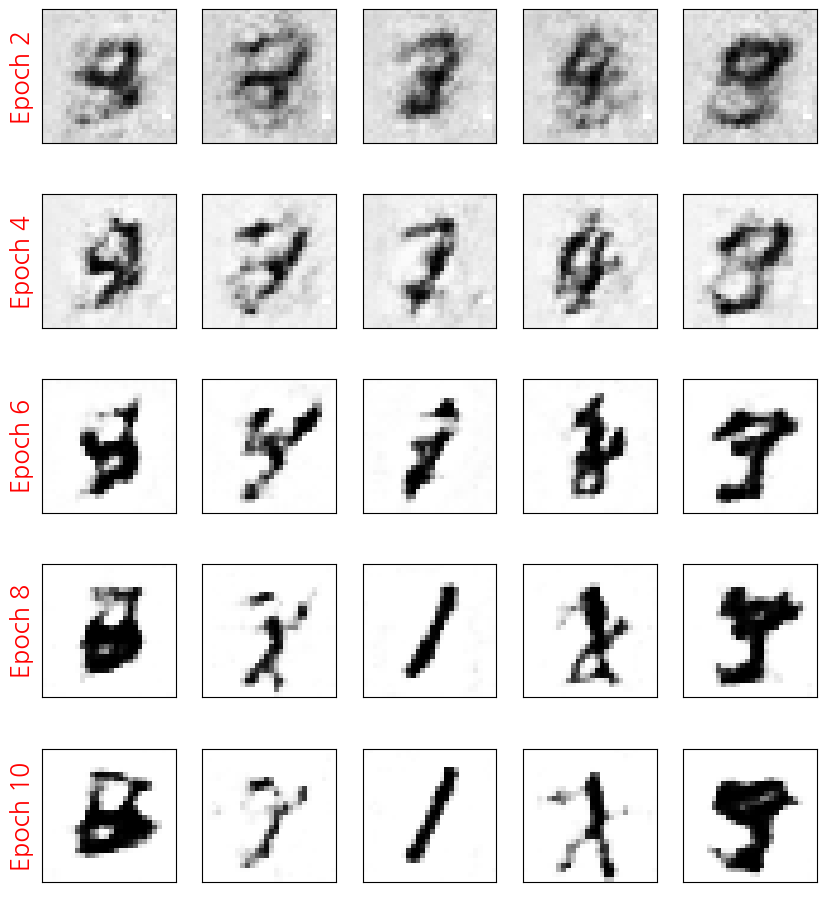

In [27]:
# 이미지 시각화
selected_epochs = [2, 4, 6, 8, 10]  # 선택한 에포크 리스트

# 시각화할 이미지를 나타내는 그림(figure) 생성
fig = plt.figure(figsize=(10, 14))

# 선택한 에포크에 대해 루프 실행
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)  # 그림에 서브플롯 추가
        ax.set_xticks([])  # x축 눈금 비활성화
        ax.set_yticks([])  # y축 눈금 비활성화
        
        if j == 0:
            # 서브플롯의 첫 번째 열에 에포크 정보 텍스트 추가
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        # 선택한 에포크와 인덱스에 해당하는 이미지 가져오기
        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')  # 이미지를 서브플롯에 표시

plt.show()  # 그림 출력